# First we need to import a number of libraries including our custom functions
There is some overlap in our plotting, but it's nice to be able to both make quick histograms of our data and to have more interactive versions using Bokeh

In [23]:
import importlib
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import os
from textwrap import wrap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import eli5
import cleanfunc
import re
from sklearn.metrics import r2_score
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
importlib.reload(cleanfunc)

<module 'cleanfunc' from 'C:\\Users\\cartechr\\OneDrive - Mars Inc\\GitHub\\ABS-Region-Data\\cleanfunc.py'>

We're going to just read in the pre-prepared data. Functions are included in cleanfunc.py to read the raw excel files you can get from the ABS, but this can take significant time to process, so we have exported the cleaned data for use here

In [ ]:
df = pd.read_csv('df.csv', index_col = "LABEL")
df.head()


We're interested in looking at the cycling data. There are a number of different region sizes, so it makes sense to normalise the cyclists by the number of households in an area.

The value we are trying to predict (y) is then this column. We should drop this column from our original dataframe to create X

In [3]:
cycle_col = 'METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.'
residents_col = 'ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.'
y = df[cycle_col]/df[residents_col]
y.index = df.index
X = df.drop([cycle_col, residents_col], axis = 1)


Let's visually explore our data to see what we're working with

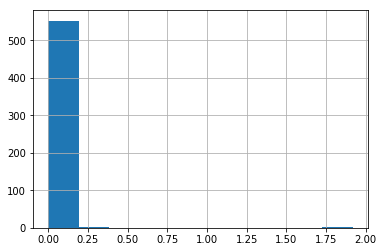

In [4]:
y.hist()

We can see that there is a real outlier at the top. This will skew our analysis so we should probably drop it. But let's investigate it first

In [5]:
print(df.loc[y>0.1,[cycle_col, residents_col]])
print("Median population of each region: {}".format(df[residents_col].median()))

                  METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.  \
LABEL                                                                                         
Lord Howe Island                                          54.000000                           
Badgerys Creek                                            44.129032                           

                  ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.  
LABEL                                                                                         
Lord Howe Island                                              194.0                           
Badgerys Creek                                                 23.0                           
Median population of each region: 6445.0


Both of these outliers have extremely small resident population which when combined with a moderate number of cyclists gives an unusual result. We will drop both these points from our analysis

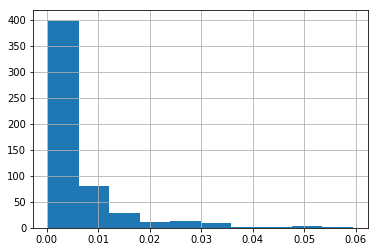

In [6]:
X = X[y<0.1]
y = y[y<0.1]

y.hist()

That's a little better, though we still have a significant cluster below the 1% mark. We might deal with that later.

# Machine Learning - First Pass
Now that we have a clean dataframe, we would like to apply some machine learning to it to see if we can predict the number of cyclists. Once we can make predictions, we can interrogate those predictions to see what's going on.

In [7]:
y_binned = np.digitize(y, y.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y_binned)

In [8]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    output_notebook()

    hover = HoverTool()
    test_source = ColumnDataSource(data=dict(
        x=y_test,
        y=y_pred,
        desc=y_test.index,
    ))

    train_source = ColumnDataSource(data=dict(
        x=y_train,
        y=y_train_pred,
        desc=y_train.index,
    ))

    p = figure(plot_width = 600, plot_height = 400, x_axis_label = 'Acutal', y_axis_label = 'Prediction')

    p.circle('x', 'y', size=20, color = 'navy', alpha = 0.5, source = test_source, legend = 'Test Data')
    p.circle('x', 'y', size=10, color = 'red', alpha = 0.5, source = train_source, legend = 'Train Data')
    p.line([0,max(y_test)],[0, max(y_test)], legend = 'line of perfect fit')
    hover.tooltips = [
        ("index", '$index'),
        ("(x,y)", "($x, $y)"),
        ("desc", "@desc"),
    ]

    p.tools.append(hover)
    p.legend.location = 'top_left'
    p.legend.click_policy="hide"
    show(p)
    print("Train data R2 score: {}".format(r2_score(y_train, y_train_pred)))
    print("Test data R2 score: {}".format(r2_score(y_test, y_pred)))
    return y_pred, y_train_pred

y_pred, y_train_pred = evaluate_model(rf, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.9525115043377248
Test data R2 score: 0.5194135463236016


A 50% r2 score on out test data isn't too bad! But the fact that we're getting a 95% R2 score on our train data would suggest that we're over-fitting quite a bit. Let's do some grid-searching to see if we can improve this model

In [10]:
print('Test data R2 score for values below 1% cyclists: {:0.2f}'.format(r2_score(y_test[y_test<0.01], y_pred[y_test<0.01])))
print('Proportion of data below 0.02: {:0.2f}%'.format(100*sum(y_test<0.01)/y_test.shape[0]))

Test data R2 score for values below 1% cyclists: -0.86
Proportion of data below 0.02: 84.68%


In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [12]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_

In [ ]:
y_best_pred, y_best_train_pred = evaluate_model(best_random, X_train, X_test, y_train, y_test)

Compared to our old R2 score of 0.50 we have a 2% increase. Not a lot, but it's something! Mousing over the higher values shows that a large number of them are in inner sydney. The bulk of the values are below 2% cyclists. I wonder if the model is being overwhelmed by signal at the high end, meaning it isn't picking up the more subtle signals at the low end. I'm going to recut the dataframe and rebuild our analysis to check.

In [ ]:
print('Test data R2 score for values below 1% cyclists: {:0.2f}'.format(r2_score(y_test[y_test<0.01], y_best_pred[y_test<0.01])))
print('Proportion of data below 0.02: {:0.2f}%'.format(100*sum(y_test<0.01)/y_test.shape[0]))

With an R2 value which is negative, we can see that our model is worse than simply taking the average of the data at predicting low end values. Given that this subset holds nearly 85% of all our data, this is definitely something we want to address

In [31]:
y_trunc = y[y<0.02]
X_trunc = X[y<0.02]

We can now reuse our code from earlier to process and graph the data.

In [32]:
y_binned = np.digitize(y_trunc, y_trunc.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test = train_test_split(X_trunc, y_trunc, test_size = 0.2, random_state = 43, stratify = y_binned)

In [33]:
rf_trunc = RandomForestRegressor(n_estimators=200)
rf_trunc.fit(X_trunc_train, y_trunc_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
y_low_pred, y_low_train_pred = evaluate_model(rf_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

Loading BokehJS ...

Train data R2 score: 0.9082215362078521
Test data R2 score: 0.46322243941860564


In [ ]:
importlib.reload(cleanfunc)
cleanfunc.feature_impact_plot(rf_trunc, X_trunc_train, 10, 'Cycling to Work')

In [17]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_trunc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_trunc.fit(X_trunc_train, y_trunc_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min


KeyboardInterrupt: 

In [ ]:
print(rf_random.best_params_)
best_trunc = rf_random_trunc.best_estimator_
y_best_pred, y_best_train_pred = evaluate_model(best_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)